# [컴페티션] 딥러닝 컴페티션
- 대회 주제 : Forecasting Mini-Course Sales
- 대회 링크 : https://www.kaggle.com/competitions/playground-series-s3e19
- 평가 항목 : SMAPE
- 제출일 : 2025년 01월 02일 목요일 8교시
- 평가 항목 점수 : 55.73186 / 54.61159
- 수강생 성함 : 송현서

In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('../input/playground-series-s3e19/train.csv')
test = pd.read_csv('../input/playground-series-s3e19/test.csv')
test['num_sold'] = 300  # this is dummy for simplify concat


In [68]:
train

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641


# Preprocessing

In [69]:
def preprocessing_all(data):

    # Creating variables for analysis
    analysis = data.drop(columns='id')

    # date column is separated for each element
    # 시계열을 각각의 요소로 분해

    analysis['date'] = pd.to_datetime(analysis['date'])
    analysis['day'] = analysis['date'].dt.day
    analysis['week'] = analysis['date'].dt.dayofweek
    analysis['month'] = analysis['date'].dt.month
    analysis['year'] = analysis['date'].dt.year
    analysis['day_of_year'] = analysis['date'].dt.dayofyear
    analysis['time_no'] = (
        analysis['date'] - dt.datetime(2017, 1, 1)
    ) // dt.timedelta(days=1)

    analysis.loc[analysis['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1
    date_columns = ['date', 'day', 'week', 'month', 'year', 'time_no']

    df = analysis.groupby(['date', 'country'], as_index=False).mean(numeric_only=True)
    df_not_outlier = df.copy()
    df_not_outlier = df_not_outlier.loc[df_not_outlier['month'].isin([1,2])]
    df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 2) | (df_not_outlier['day'] >= 11)]
    df_not_outlier = df_not_outlier.loc[(df_not_outlier['month'] == 1) | (df_not_outlier['day'] <= 14)]
    change = df_not_outlier.groupby(['country', 'year'], as_index=False).mean()
    change = change[['country', 'year', 'num_sold']]

    for year in [2017,2018,2019,2020,2021]:
        df = pd.merge(df, change.loc[change['year']==year].rename(columns={'num_sold':f'c{year}'}).drop(columns='year'),
                  on=['country'])
    df.loc[df['year'] == 2017, 'num_sold'] /= df['c2017']
    df.loc[df['year'] == 2018, 'num_sold'] /= df['c2018']
    df.loc[df['year'] == 2019, 'num_sold'] /= df['c2019']
    df.loc[df['year'] == 2020, 'num_sold'] /= df['c2020']
    df.loc[df['year'] <2021, 'num_sold'] *= df['c2021']

    return analysis, df

In [96]:
def preprocessing_test(data):

    # Creating variables for analysis
    analysis = data.drop(columns='id')

    # date column is separated for each element
    # 시계열을 각각의 요소로 분해

    analysis['date'] = pd.to_datetime(analysis['date'])
    analysis['day'] = analysis['date'].dt.day
    analysis['week'] = analysis['date'].dt.dayofweek
    analysis['month'] = analysis['date'].dt.month
    analysis['year'] = analysis['date'].dt.year
    analysis['day_of_year'] = analysis['date'].dt.dayofyear
    analysis['time_no'] = (
        analysis['date'] - dt.datetime(2017, 1, 1)
    ) // dt.timedelta(days=1)

    analysis.loc[analysis['date'] > dt.datetime(2020, 2, 29), 'time_no'] -= 1

    # Create an instance of LabelEncoder
    le = LabelEncoder()
    # Fit and transform the data

    analysis['country'] = le.fit_transform(analysis['country'])
    analysis['store'] = le.fit_transform(analysis['store'])
    analysis['product'] = le.fit_transform(analysis['product'])

    return analysis

In [70]:
analysis, df = preprocessing_all(train)

# preprocess for LSTM


In [71]:
from scipy.stats import levene, shapiro
int_cols=analysis.select_dtypes(exclude='object').columns.to_list()

for i in int_cols:
    _, p_value=shapiro(analysis[i])
    if p_value<0.05:
        print("Feature {} is normaly distributed".format(i))
    else:
        print("Feature {} is not normaly distributed".format(i))
        
    print("Normalitiy test p_value for featue -  {} is {}".format(i,np.round(p_value,3)))

Feature date is normaly distributed
Normalitiy test p_value for featue -  date is 0.0
Feature num_sold is normaly distributed
Normalitiy test p_value for featue -  num_sold is 0.0
Feature day is normaly distributed
Normalitiy test p_value for featue -  day is 0.0
Feature week is normaly distributed
Normalitiy test p_value for featue -  week is 0.0
Feature month is normaly distributed
Normalitiy test p_value for featue -  month is 0.0
Feature year is normaly distributed
Normalitiy test p_value for featue -  year is 0.0
Feature day_of_year is normaly distributed
Normalitiy test p_value for featue -  day_of_year is 0.0
Feature time_no is normaly distributed
Normalitiy test p_value for featue -  time_no is 0.0


In [72]:
analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         136950 non-null  datetime64[ns]
 1   country      136950 non-null  object        
 2   store        136950 non-null  object        
 3   product      136950 non-null  object        
 4   num_sold     136950 non-null  int64         
 5   day          136950 non-null  int32         
 6   week         136950 non-null  int32         
 7   month        136950 non-null  int32         
 8   year         136950 non-null  int32         
 9   day_of_year  136950 non-null  int32         
 10  time_no      136950 non-null  int64         
dtypes: datetime64[ns](1), int32(5), int64(2), object(3)
memory usage: 8.9+ MB


In [73]:
df.info

<bound method DataFrame.info of            date    country    num_sold   day  week  month    year  \
0    2017-01-01  Argentina   98.917755   1.0   6.0    1.0  2017.0   
1    2017-01-02  Argentina   73.143064   2.0   0.0    1.0  2017.0   
2    2017-01-03  Argentina   71.224718   3.0   1.0    1.0  2017.0   
3    2017-01-04  Argentina   66.748579   4.0   2.0    1.0  2017.0   
4    2017-01-05  Argentina   64.731857   5.0   3.0    1.0  2017.0   
...         ...        ...         ...   ...   ...    ...     ...   
9125 2021-12-27      Spain  211.466667  27.0   0.0   12.0  2021.0   
9126 2021-12-28      Spain  239.600000  28.0   1.0   12.0  2021.0   
9127 2021-12-29      Spain  273.733333  29.0   2.0   12.0  2021.0   
9128 2021-12-30      Spain  262.400000  30.0   3.0   12.0  2021.0   
9129 2021-12-31      Spain  262.666667  31.0   4.0   12.0  2021.0   

      day_of_year  time_no       c2017       c2018       c2019       c2020  \
0             1.0      0.0   79.750476   66.748571   55.56190

In [74]:
cat_cols = analysis.select_dtypes(exclude = np.number).columns.tolist()[1:]
num_cols = analysis.select_dtypes(include = np.number).columns.tolist()

print(cat_cols)
print(num_cols)

['country', 'store', 'product']
['num_sold', 'day', 'week', 'month', 'year', 'day_of_year', 'time_no']


In [75]:
cat_cols_df = df.select_dtypes(exclude = np.number).columns.tolist()[1:]
num_cols_df = df.select_dtypes(include = np.number).columns.tolist()

print(cat_cols)
print(num_cols)

['country', 'store', 'product']
['num_sold', 'day', 'week', 'month', 'year', 'day_of_year', 'time_no']


In [76]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()
# Fit and transform the data

analysis['country'] = le.fit_transform(analysis['country'])
analysis['store'] = le.fit_transform(analysis['store'])
analysis['product'] = le.fit_transform(analysis['product'])

analysis.head()

,date,country,store,product,num_sold,day,week,month,year,day_of_year,time_no
0,2017-01-01,0,1,0,63,1,6,1,2017,1,0
1,2017-01-01,0,1,1,66,1,6,1,2017,1,0
2,2017-01-01,0,1,2,9,1,6,1,2017,1,0
3,2017-01-01,0,1,3,59,1,6,1,2017,1,0
4,2017-01-01,0,1,4,49,1,6,1,2017,1,0


In [77]:
y = analysis.pop('num_sold')
X = analysis.drop('date', axis = 1)

In [78]:
'''
y = df.pop('num_sold')
X = df.drop('date', axis = 1)
'''

"\ny = df.pop('num_sold')\nX = df.drop('date', axis = 1)\n"

In [79]:
# But this is Time series, should we use other split method?

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, shuffle = False, random_state = 42
)

# Autoencoder

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector,TimeDistributed
from tensorflow.keras import optimizers, Sequential, Model

epochs = 10
batch = 128
lr = 0.0001

encoder_decoder = Sequential()
encoder_decoder.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1), return_sequences=True))
#encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(1, activation='relu'))
encoder_decoder.add(RepeatVector(X.shape[1]))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(50, activation='relu', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 9, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 1)                   │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 9, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 9, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 9, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 9, 1)                │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,259 (555.70 KB)

 Trainable params: 142,259 (555.70 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, 
                                              #validation_data=(X_test,y_test),
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=1)

Epoch 1/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 340555.2812
Epoch 2/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 30079.1426
Epoch 3/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2608.8599
Epoch 4/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1777.7643
Epoch 5/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1884.6766
Epoch 6/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2200.1350
Epoch 7/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1570.3966
Epoch 8/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 1552.8536
Epoch 9/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 323035.7188
Epoch 10/10
856/856 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 67040.8203


In [82]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[4].output)

In [83]:
train_encoded = encoder.predict(X_train)
test_encoded = encoder.predict(X_test)
print('Encoded time-series shape', train_encoded.shape)

3424/3424 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Encoded time-series shape (109560, 1)


In [84]:
X_train['encoded'] = train_encoded

X_test['encoded'] = test_encoded

# LSTM - RNN

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 10, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 10, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs = 20, batch_size = 32)

Epoch 1/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - loss: 46167.9609 - val_loss: 41415.9414
Epoch 2/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 32858.5312 - val_loss: 37004.1992
Epoch 3/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 29400.5469 - val_loss: 35762.9258
Epoch 4/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 29242.4043 - val_loss: 35633.7734
Epoch 5/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 29141.8711 - val_loss: 35659.0039
Epoch 6/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 29339.5293 - val_loss: 35699.3008
Epoch 7/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 29075.0098 - val_loss: 29207.3320
Epoch 8/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 19079.2598 - val_loss: 18141.9824
Epoch 9/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 13505.6123 - val_loss: 15349.2305
Epoch 10/20
3424/3424 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 11685.7646 - val_loss: 7617.2217
Epoch 11/20
3424/3424 ━━━━━━━━

# Res

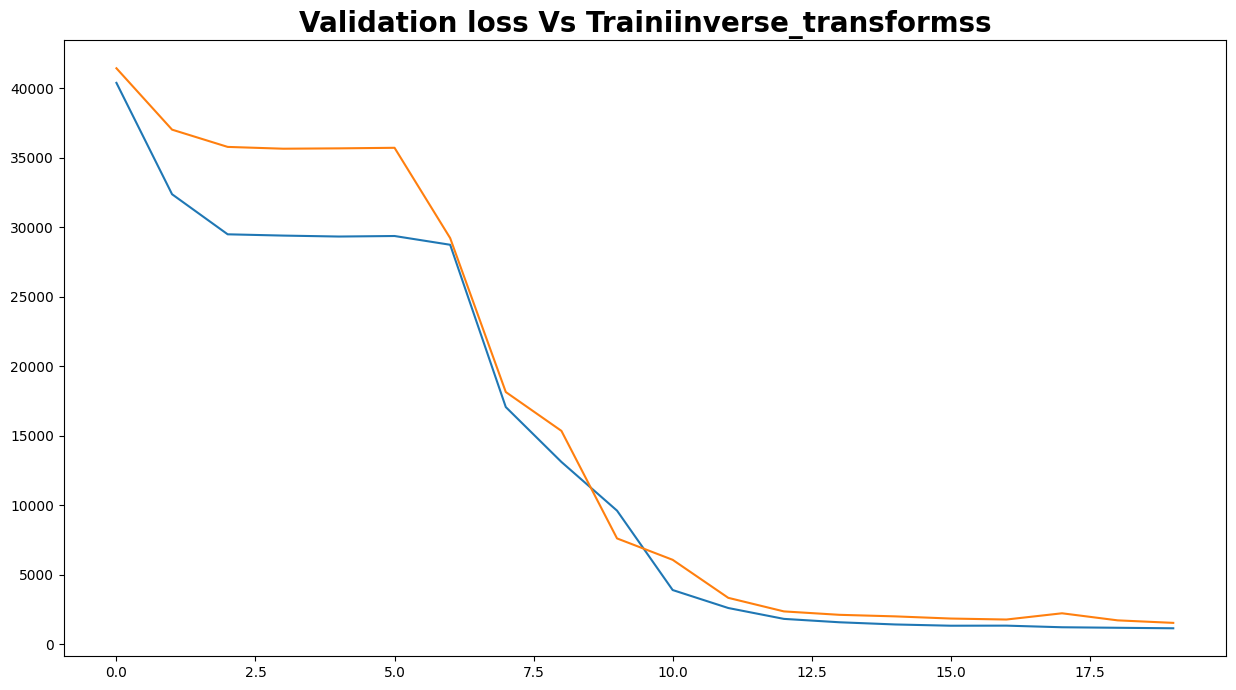

In [87]:
loss = pd.DataFrame(model.history.history)
fig=plt.figure(figsize=(15,8))
plt.title("Validation loss Vs Trainiinverse_transformss", size=20, weight='bold')
plt.plot(loss)

# Predict

In [89]:
test

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better
...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions


In [99]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')
test = pd.read_csv('../input/playground-series-s3e19/test.csv')

sub_analysis = preprocessing_test(test)
sub_analysis.head(3)

In [101]:
Xtest = sub_analysis.drop('date', axis = 1)
testencoded = encoder.predict(Xtest)

Xtest['encoded'] = testencoded

856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [102]:
pred=model.predict(Xtest)

856/856 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [110]:
sub

,id,num_sold
0,136950,28.241453
1,136951,28.642128
2,136952,26.451246
3,136953,9.474547
4,136954,8.824790
...,...,...
27370,164320,567.173157
27371,164321,579.997131
27372,164322,78.257225
27373,164323,545.314697


In [103]:
sub['num_sold']=pred
sub = sub.rename(columns={'Unnamed: 0': 'id'})
sub.to_csv('submission.csv',index=False)

In [111]:
sub.head()

,id,num_sold
0,136950,28.241453
1,136951,28.642128
2,136952,26.451246
3,136953,9.474547
4,136954,8.824790


<Axes: >

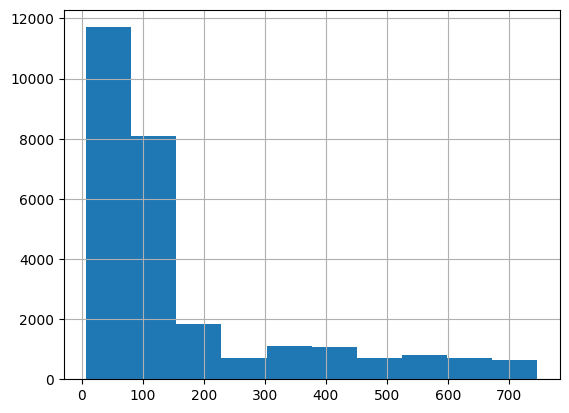

In [112]:
sub['num_sold'].hist()